# 02. Neural network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as options).

## 1. Make classification data and get it ready

In [1]:
import torch
from torch import nn
import sklearn

In [2]:
from sklearn.datasets import make_circles

# make 1000 samples :
n_samples = 1000

# create circles :
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Make dataframe of circle data :
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


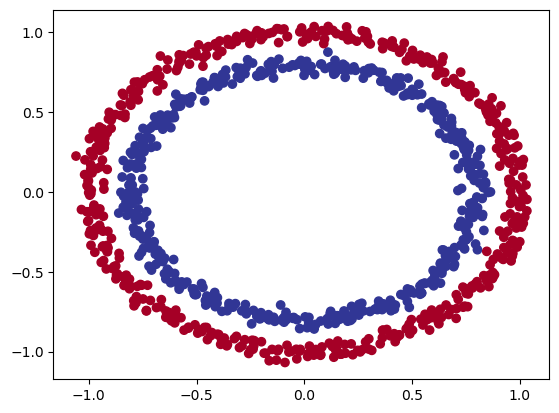

In [6]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note : the data we're working with is often referred to as a toy dataset, that is a dataset small enough to experiment with but large enough to practice the fundamentals

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [81]:
X

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        ...,
        [-0.1369, -0.8100],
        [ 0.6704, -0.7675],
        [ 0.2811,  0.9638]])

In [9]:
# view the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors, create train and test splits

In [10]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [11]:
# Turn data into tensors 
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
# Split data into training and test sets, X is features, y is labels
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [82]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.
To do so, we want to:
1. Setup device agnostic code
2. Construct a model (by subclassing `nn.Module`), it will have 2 `nn.Linear()` layers capable of handling the shapes of our data
3. Define a loss function and optimizer
4. Create a training and test loop

In [14]:
# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
# torch.set_default_device(torch.device(device))
print(f"Using device: {device}")

Using device: mps


In [83]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)  # takes in two features, scales up to 5 numbers
        self.layer_2 = nn.Linear(in_features=5,
                                 out_features=1)  # takes in the 5 features and scales down to 1 number, output layer with same shape as y

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer2(self.layer_1(x))  # x -> layer 1 -> layer 2 -> output


model_0 = CircleModelV0()
model_0.to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
next(model_0.parameters()).device

device(type='mps', index=0)

In [17]:
# Replicate the model above using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [84]:
# Make predictions
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='mps:0')),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='mps:0')),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='mps:0')),
             ('layer_2.bias', tensor([-0.2060], device='mps:0'))])

In [19]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-1.],
        [-1.],
        [ 0.],
        [-1.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [-1.]], device='mps:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [20]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?
This is problem specific. 
For example, for regression you might want mean absolute error, or mean squared error.
For classification, you might want binary cross entropy or categorical cross entropy.

Reminder: the loss function measures how *wrong* your model's predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however, Pytorch has many built-in options.

* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`

In [21]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss = has the sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [22]:
# Calculate accuracy - out of 100 example, what percentage does the model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model

To train our model, we're going to build a training loop:
1. Forward pass
2. Calculate loss
3. Zero grad
4. Loss backward (backprop)
5. Optimizer step

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary cross-entropy and softmax for multiclass classification).

Then we can convert our model's prediction probabilities into **prediction labels** by either rounding them, or taking the `argmax()`.

In [23]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.5379],
        [-0.5264],
        [-0.4040],
        [-0.5766],
        [-0.1434]], device='mps:0')

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [25]:
# use the sigmoid activation function on the logits to turn them into prediction probabilities :
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3687],
        [0.3714],
        [0.4003],
        [0.3597],
        [0.4642]], device='mps:0')

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >=0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5 `y=0` (class 0)

In [26]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# in full (logits -> prediction probabilities -> prediction labels):
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra dimension 
y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([0., 0., 0., 0., 0.], device='mps:0')

In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building the training and testing loop

In [28]:
torch.manual_seed(42)

epochs = 100

# move the data to the correct device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### training
    model_0.train()
    # forward pass :
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(
        y_logits))  # turn logits which are the output of the model into pred probs and then into pred labels

    # calculate loss and accuracy
    #loss = loss_fn(torch.sigmoid(y_logits),  # nn.BCELoss expects prediction probabilities as input 
    #               y_train)
    loss = loss_fn(y_logits,  # nn.BCEWithLogitsLoss expects raw logits as input
                   y_train)

    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # zero grad
    optimizer.zero_grad()

    # backpropagation
    loss.backward()

    # optimizer step
    optimizer.step()

    ### testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print out what is happening :
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71178 | Accuracy: 50.00% | Test loss: 0.70782 | Test accuracy: 50.00%
Epoch: 10 | Loss: 0.69999 | Accuracy: 49.50% | Test loss: 0.69682 | Test accuracy: 49.00%
Epoch: 20 | Loss: 0.69620 | Accuracy: 44.75% | Test loss: 0.69333 | Test accuracy: 46.00%
Epoch: 30 | Loss: 0.69487 | Accuracy: 46.75% | Test loss: 0.69221 | Test accuracy: 51.00%
Epoch: 40 | Loss: 0.69431 | Accuracy: 47.75% | Test loss: 0.69189 | Test accuracy: 49.00%
Epoch: 50 | Loss: 0.69402 | Accuracy: 48.00% | Test loss: 0.69184 | Test accuracy: 51.50%
Epoch: 60 | Loss: 0.69384 | Accuracy: 48.38% | Test loss: 0.69190 | Test accuracy: 52.00%
Epoch: 70 | Loss: 0.69371 | Accuracy: 48.25% | Test loss: 0.69199 | Test accuracy: 53.00%
Epoch: 80 | Loss: 0.69361 | Accuracy: 48.75% | Test loss: 0.69210 | Test accuracy: 53.50%
Epoch: 90 | Loss: 0.69353 | Accuracy: 48.62% | Test loss: 0.69222 | Test accuracy: 53.00%


In [29]:
loss_fn

BCEWithLogitsLoss()

## 4. Make predictions and evaluate the model

From the metrics, it looks like our model is not learning anything.

To inspect it let's make some predictions and make them visual.

To do so, we will import a function called `plot_decision_boundary()`

In [30]:
import requests
from pathlib import Path

# download helper functions from Learn PyTorch repo if not already downloaded
if Path("helper_functions.py").is_file():
    print("Helper functions already exist")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Helper functions already exist


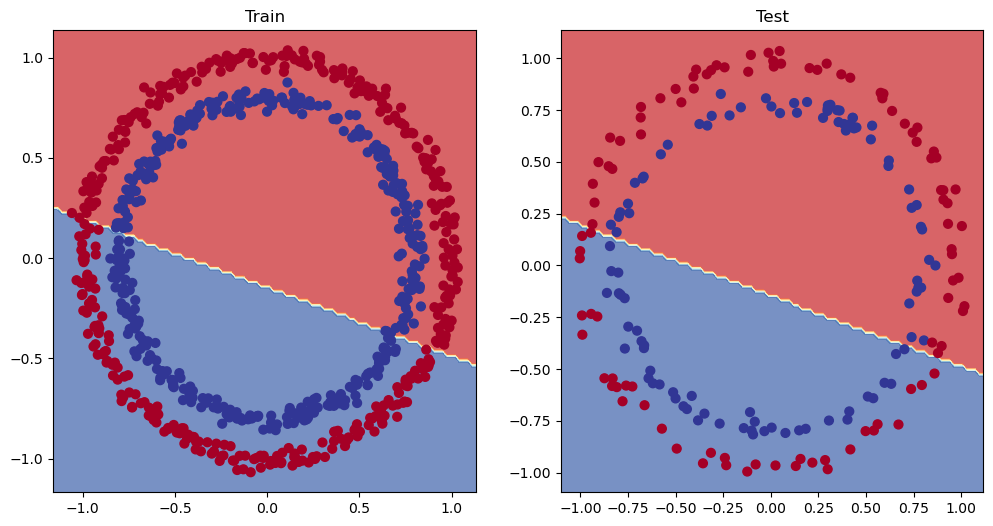

In [31]:
# Plot decision boundary of the model :
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # rows, cols, index
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn the patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective, as they all deal with the model and not the data.

The above are all **hyperparameters**.

We will try to:
* add more hidden units 5 -> 10
* increase the number of layers 2 -> 3
* increase the number of epochs 100 -> 1000

In [32]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.layer_2(self.layer_1(x)))


model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss = has the sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [34]:
torch.manual_seed(42)

epochs = 1000

# move the data to the correct device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### training
    model_1.train()
    # forward pass :
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(
        y_logits))  # turn logits which are the output of the model into pred probs and then into pred labels

    loss = loss_fn(y_logits,  # nn.BCEWithLogitsLoss expects raw logits as input
                   y_train)

    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # zero grad
    optimizer.zero_grad()

    # backpropagation
    loss.backward()

    # optimizer step
    optimizer.step()

    ### testing
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print out what is happening :
    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396 | Accuracy: 50.88% | Test loss: 0.69261 | Test accuracy: 51.00%
Epoch: 100 | Loss: 0.69305 | Accuracy: 50.38% | Test loss: 0.69379 | Test accuracy: 48.00%
Epoch: 200 | Loss: 0.69299 | Accuracy: 51.12% | Test loss: 0.69437 | Test accuracy: 46.00%
Epoch: 300 | Loss: 0.69298 | Accuracy: 51.62% | Test loss: 0.69458 | Test accuracy: 45.00%
Epoch: 400 | Loss: 0.69298 | Accuracy: 51.12% | Test loss: 0.69465 | Test accuracy: 46.00%
Epoch: 500 | Loss: 0.69298 | Accuracy: 51.00% | Test loss: 0.69467 | Test accuracy: 46.00%
Epoch: 600 | Loss: 0.69298 | Accuracy: 51.00% | Test loss: 0.69468 | Test accuracy: 46.00%
Epoch: 700 | Loss: 0.69298 | Accuracy: 51.00% | Test loss: 0.69468 | Test accuracy: 46.00%
Epoch: 800 | Loss: 0.69298 | Accuracy: 51.00% | Test loss: 0.69468 | Test accuracy: 46.00%
Epoch: 900 | Loss: 0.69298 | Accuracy: 51.00% | Test loss: 0.69468 | Test accuracy: 46.00%


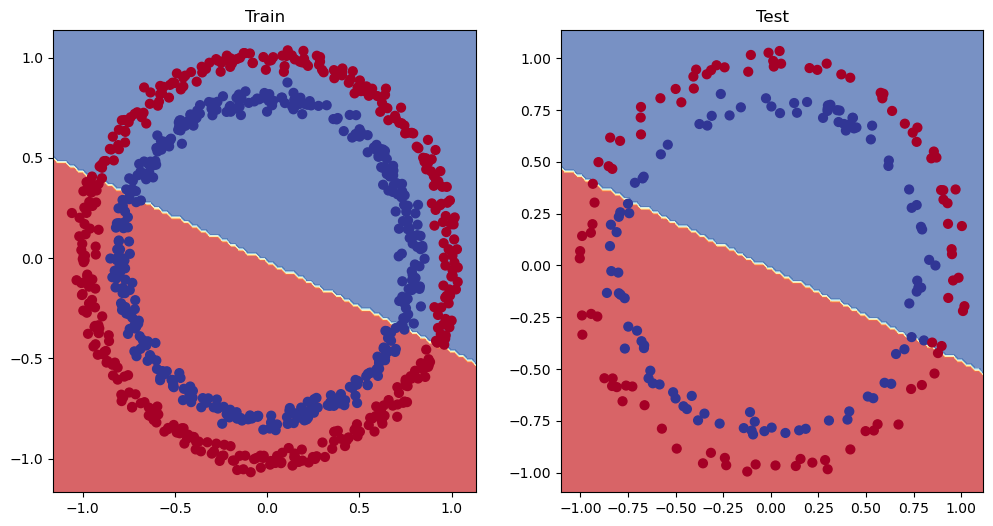

In [35]:
# Plot decision boundary of the model :
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # rows, cols, index
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test out a smaller problem.

In [36]:
# create some data like in the previous notebook
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01
X_regression = torch.arange(start, end, step=step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# check the data
print(len(X_regression), len(y_regression))
X_regression[:5], y_regression[:5]



100 100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [37]:
# create the train and test splits :
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]

X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

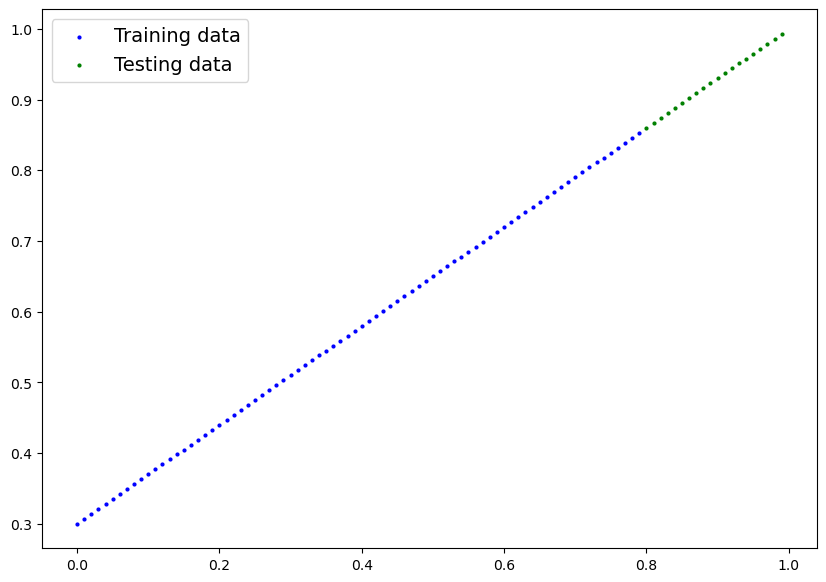

In [38]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [39]:
# same architecture as model_1 but using nn.Sequential() :
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

In [40]:
# loss and optimizer :
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [41]:
torch.manual_seed(42)
epochs = 1000

# put data on target device :
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)

X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    model_2.train()
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    # print out the stuff :
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.00721 | Test loss: 0.01370
Epoch: 200 | Loss: 0.01449 | Test loss: 0.03380
Epoch: 300 | Loss: 0.02462 | Test loss: 0.00681
Epoch: 400 | Loss: 0.01597 | Test loss: 0.03552
Epoch: 500 | Loss: 0.01600 | Test loss: 0.01258
Epoch: 600 | Loss: 0.01084 | Test loss: 0.01265
Epoch: 700 | Loss: 0.02270 | Test loss: 0.00159
Epoch: 800 | Loss: 0.01194 | Test loss: 0.04416
Epoch: 900 | Loss: 0.01374 | Test loss: 0.04298


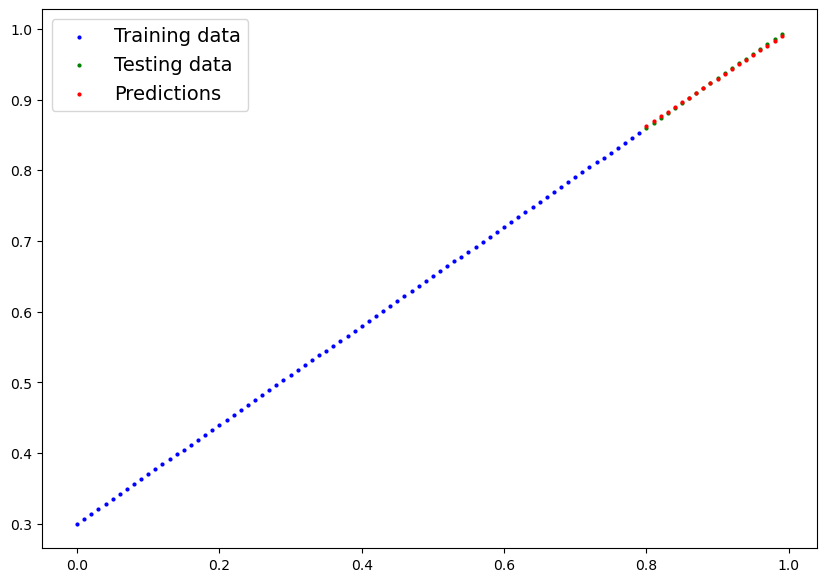

In [42]:
model_2.eval()
with torch.inference_mode():
    preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(), train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(), test_labels=y_test_regression.cpu(), predictions=preds.cpu())

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) amount of linear and non-linear functions?

### Recreating non-linear data (red and blue circles)


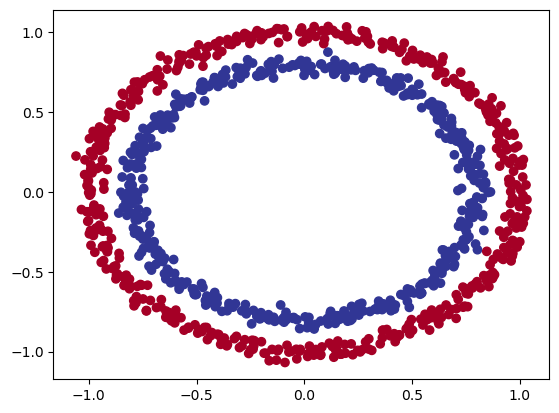

In [43]:
# make and plot data :
n_samples = 1000
X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [44]:
# Turn data into tensors 
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


# split :
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [45]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Where should we put the non-linear activation functions?
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


In [46]:
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [47]:
# loss and optimizer :
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [48]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
#Training :

torch.manual_seed(42)


epochs = 1500

for epoch in range(epochs):
    model_3.train()
    # fwd pass :
    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # calc loss
    loss = loss_fn(y_logits,
                   y_train)

    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    #zero grad
    optimizer.zero_grad()

    #backwards
    loss.backward()

    # step :
    optimizer.step()
    #log training info
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print out what is happening :
    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
        
    

Epoch: 0 | Loss: 0.69295 | Accuracy: 50.00% | Test loss: 0.69319 | Test accuracy: 50.00%
Epoch: 100 | Loss: 0.69115 | Accuracy: 52.88% | Test loss: 0.69102 | Test accuracy: 52.50%
Epoch: 200 | Loss: 0.68977 | Accuracy: 53.37% | Test loss: 0.68940 | Test accuracy: 55.00%
Epoch: 300 | Loss: 0.68795 | Accuracy: 53.00% | Test loss: 0.68723 | Test accuracy: 56.00%
Epoch: 400 | Loss: 0.68517 | Accuracy: 52.75% | Test loss: 0.68411 | Test accuracy: 56.50%
Epoch: 500 | Loss: 0.68102 | Accuracy: 52.75% | Test loss: 0.67941 | Test accuracy: 56.50%
Epoch: 600 | Loss: 0.67515 | Accuracy: 54.50% | Test loss: 0.67285 | Test accuracy: 56.00%
Epoch: 700 | Loss: 0.66659 | Accuracy: 58.38% | Test loss: 0.66322 | Test accuracy: 59.00%
Epoch: 800 | Loss: 0.65160 | Accuracy: 64.00% | Test loss: 0.64757 | Test accuracy: 67.50%
Epoch: 900 | Loss: 0.62362 | Accuracy: 74.00% | Test loss: 0.62145 | Test accuracy: 79.00%
Epoch: 1000 | Loss: 0.56818 | Accuracy: 87.75% | Test loss: 0.57378 | Test accuracy: 86.50%


### 6.4 Evaluating a model trained with non-linear activation functions

In [49]:
# Make predictions :
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
    
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'))

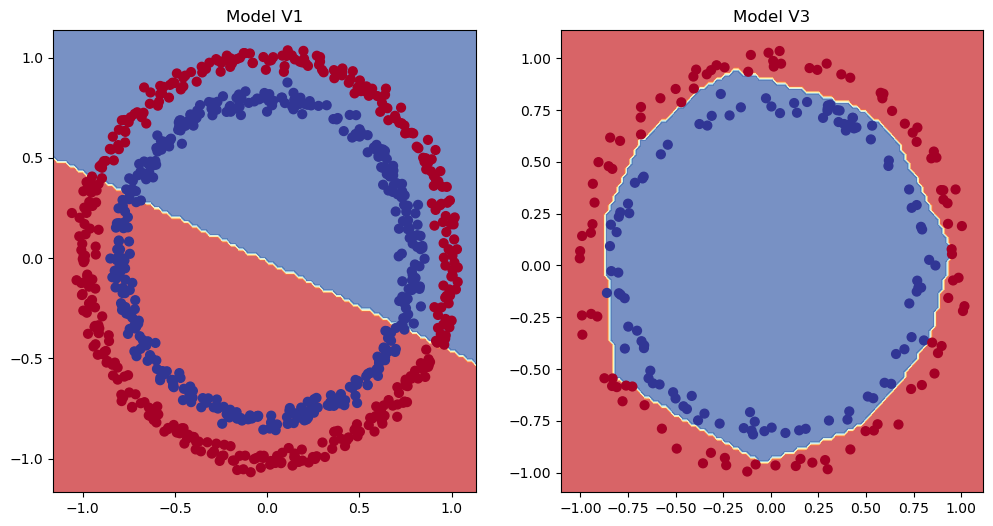

In [50]:

# Plot decision boundary of the model :
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # rows, cols, index
plt.title("Model V1")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Model V3")
plot_decision_boundary(model_3, X_test, y_test)

**Challenge**: improve the model3 to get accuracy > 80%

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the best patterns on its own.

And these tools are linear and non-linear functions.

In [51]:
# Create a tensor :
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [52]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

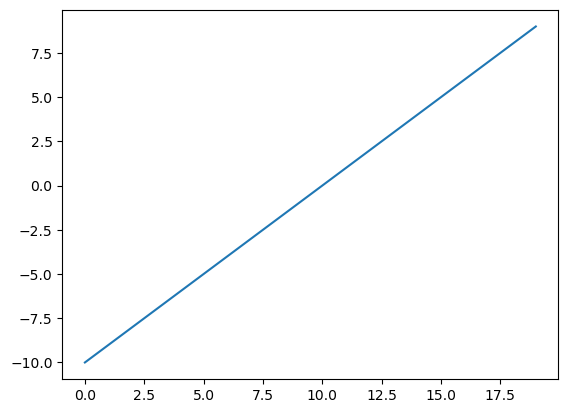

In [53]:
plt.plot(A)

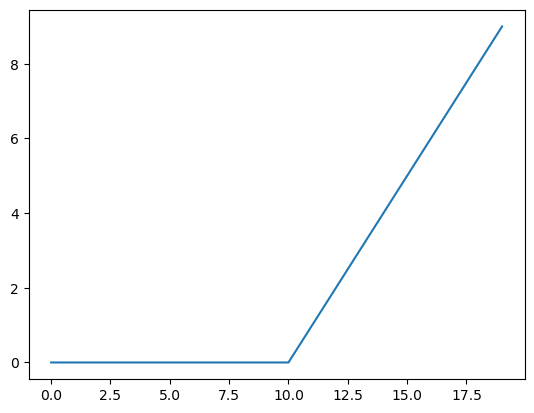

In [54]:
plt.plot(torch.relu(A))

In [55]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

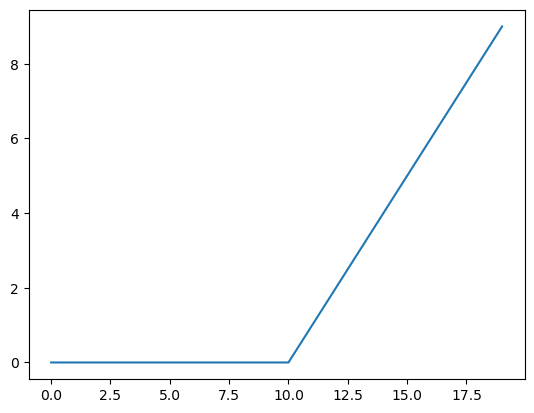

In [56]:
plt.plot(relu(A))

In [57]:
# now sigmoid
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

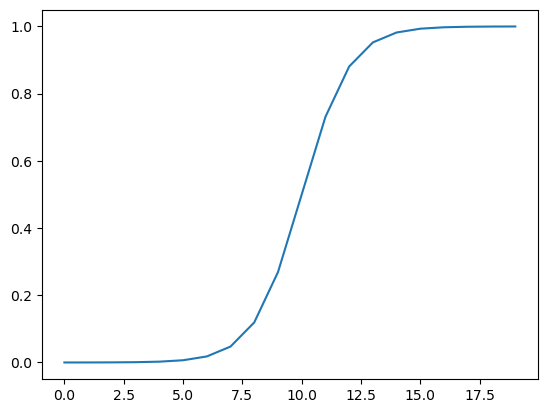

In [58]:
plt.plot(torch.sigmoid(A))

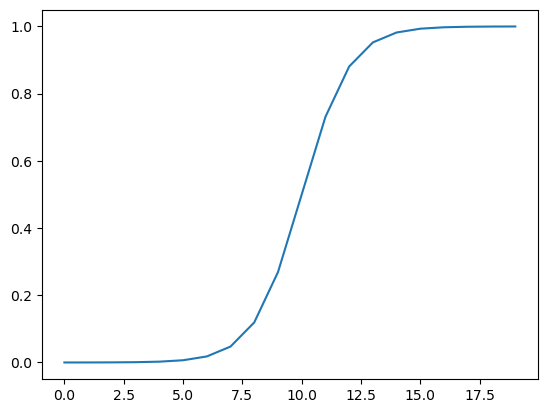

In [59]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing vs another (cat vs dog, spam vs not spam, fraud or not fraud for cc transaction)
* Multi-class classification = more than one thing vs another (cat vs dog vs chicken)

### 8.1 Create a toy multi-class dataset

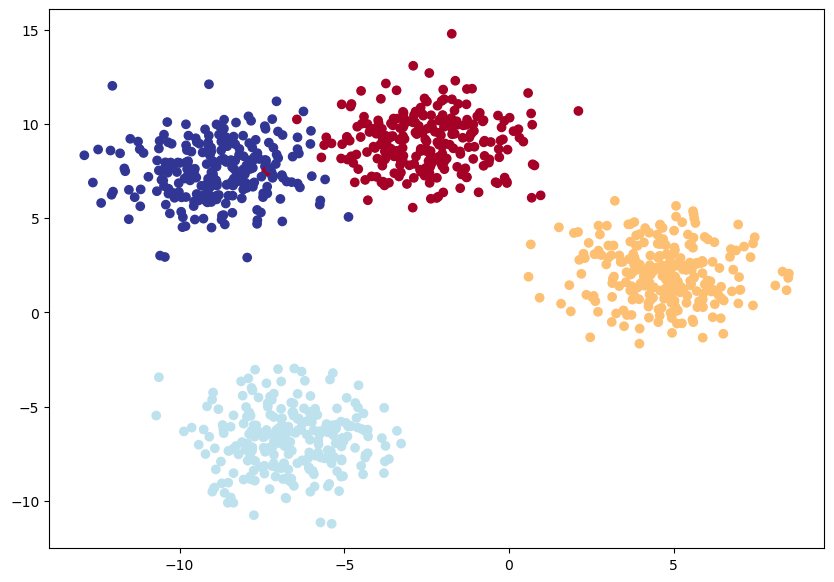

In [60]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyper parameters for data creation :
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. create multiclass data :
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. turn data into tensors :
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.long)

# 3. split into train and test 
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot the data :
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [61]:
# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
# torch.set_default_device(torch.device(device))
print(f"Using device: {device}")

Using device: mps


In [62]:
# Build a multi-class classification model :
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes multiclass classification model.
        
        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features of the model
            hidden_units (int): Number of hidden units between layers, default 8
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
        
    def forward(self, x):
        return self.linear_layer_stack(x)
    

# create an instance of blobModel and send it to target device :
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [63]:
loss_fn = torch.nn.CrossEntropyLoss()

# create an optimizer :
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

In [64]:
X_blob_train,X_blob_test, y_blob_train, y_blob_test = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model 

In order to evaluate and train and test our model, we need to convert the model's outputs (logits) to prediction probabilities and then to prediction labels. For that we need to use an activation function, in this case softmax

Logits -> Pred probs (use softmax -> Pred labels (take the argmax of the prediction probabilities)

In [65]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10], y_blob_test

(tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
         [ 1.7168, -1.2270,  1.7367,  2.1010],
         [ 2.2400,  0.7714,  2.6020,  1.0107],
         [-0.7993, -0.3723, -0.9138, -0.5388],
         [-0.4332, -1.6117, -0.6891,  0.6852],
         [ 2.0878, -1.3728,  2.1248,  2.5052],
         [ 1.8310,  0.8851,  2.1674,  0.6006],
         [ 0.1412, -1.4742, -0.0360,  1.0373],
         [ 2.9426,  0.7047,  3.3670,  1.6184],
         [-0.0645, -1.5006, -0.2666,  0.8940]], device='mps:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
         2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
         0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
         3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
         1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
         2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
         2, 2, 0, 3, 3, 2,

In [66]:
# convert our model's logit outputs to pred probs :
y_pred_probs = torch.softmax(y_logits, dim=1)

y_pred_probs[:5], y_logits[:5]

(tensor([[0.1872, 0.2918, 0.1495, 0.3715],
         [0.2824, 0.0149, 0.2881, 0.4147],
         [0.3380, 0.0778, 0.4854, 0.0989],
         [0.2118, 0.3246, 0.1889, 0.2748],
         [0.1945, 0.0598, 0.1506, 0.5951]], device='mps:0'),
 tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
         [ 1.7168, -1.2270,  1.7367,  2.1010],
         [ 2.2400,  0.7714,  2.6020,  1.0107],
         [-0.7993, -0.3723, -0.9138, -0.5388],
         [-0.4332, -1.6117, -0.6891,  0.6852]], device='mps:0'))

In [67]:
torch.argmax(y_pred_probs[0])

tensor(3, device='mps:0')

In [68]:
# Convert our model's prediction probabilities to prediction labels :
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds.type(torch.int32)

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3], device='mps:0', dtype=torch.int32)

In [69]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='mps:0')

### 8.5 Create a training and testing loop for multi-class PyTorch model


In [70]:
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [71]:
y_blob_train.shape, X_blob_train.shape

(torch.Size([800]), torch.Size([800, 2]))

In [72]:
epochs = 100
torch.manual_seed(42)

for epoch in range(epochs):
    model_4.train()
    # forward pass
    y_logits = model_4(X_blob_train) # raw outputs of our model
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_preds = torch.argmax(y_pred_probs, dim=1)

    # calculate loss
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred = y_preds)
    # zero grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()
    # optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.0432 | Acc: 65.50% | Test Loss: 0.5786 | Test acc: 95.50%
Epoch: 10 | Loss: 0.1440 | Acc: 99.12% | Test Loss: 0.1304 | Test acc: 99.00%
Epoch: 20 | Loss: 0.0806 | Acc: 99.12% | Test Loss: 0.0722 | Test acc: 99.50%
Epoch: 30 | Loss: 0.0592 | Acc: 99.12% | Test Loss: 0.0513 | Test acc: 99.50%
Epoch: 40 | Loss: 0.0489 | Acc: 99.00% | Test Loss: 0.0410 | Test acc: 99.50%
Epoch: 50 | Loss: 0.0429 | Acc: 99.00% | Test Loss: 0.0349 | Test acc: 99.50%
Epoch: 60 | Loss: 0.0391 | Acc: 99.00% | Test Loss: 0.0308 | Test acc: 99.50%
Epoch: 70 | Loss: 0.0364 | Acc: 99.00% | Test Loss: 0.0280 | Test acc: 99.50%
Epoch: 80 | Loss: 0.0345 | Acc: 99.00% | Test Loss: 0.0259 | Test acc: 99.50%
Epoch: 90 | Loss: 0.0330 | Acc: 99.12% | Test Loss: 0.0242 | Test acc: 99.50%


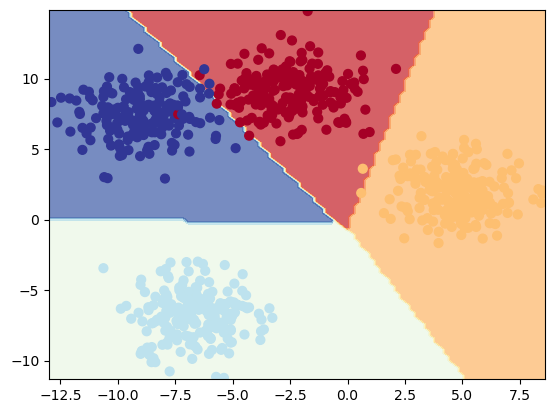

In [73]:
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

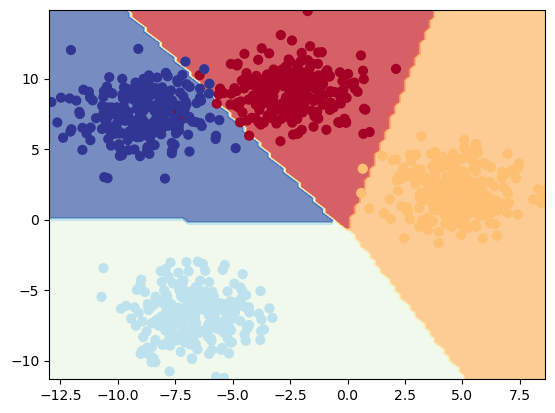

In [74]:
plot_decision_boundary(model_4, X_blob, y_blob)

In [75]:
model_4.to(device)

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [76]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
    
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7643],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5919, -18.5990,  25.5310,  17.5800],
        [  7.3142,   0.7197, -11.2018,  -1.2011]], device='mps:0')

In [77]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = torch.argmax(y_pred_probs, dim=1)

y_preds[:10], y_blob_test[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0'))

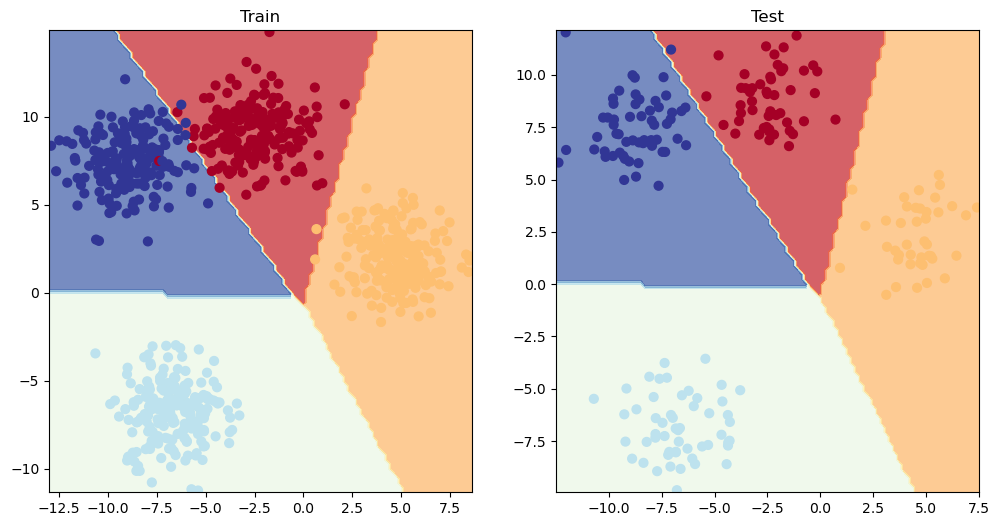

In [78]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics (to evaluate our models)

* Accuracy - out of 100 samples, how many does our model get right
* Precision - higher precision leads to less false positives
* Recall - higher recall leads to less false negatives
* F1-score - combines precision and recall, usually a good overall metric for a classification model
* Confusion matrix - when comparing predictions to truth labels to see where the model gets confused. Hard to use with large number of classes.
* Classification report

In [79]:
from torchmetrics import Accuracy

In [80]:
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# calculate accuracy : 
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='mps:0')